# Tutorial - basic example of all metrics

This notebook shows the functionality of the various metrics included in the library. 

For this purpose, we use a pre-trained ResNet-18 model and ImageNet dataset. A description for how to download the dataset can be found here: https://image-net.org/download.php.


- Make sure to have GPUs enabled to speed up computation.
- Skip running the first cell if you do not use Google Colab.

In [1]:
# Mount Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Install packages.
from IPython.display import clear_output
!pip install captum opencv-python xmltodict
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
clear_output()

In [3]:
# Imports general.
import sys
import gc
import warnings
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
import captum
from captum.attr import *
import random
import os
import cv2
import PIL
from xml.etree import ElementTree
import xmltodict
import collections

# Import package.
path = "/content/drive/MyDrive/Projects"
sys.path.append(f'{path}/quantus')
import quantus

# Collect garbage.
gc.collect()
torch.cuda.empty_cache()

# Configs torch (read more on this cuda-related issue here: https://github.com/pytorch/pytorch/issues/45769).
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Notebook settings.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
warnings.filterwarnings("ignore", category=UserWarning)
%load_ext autoreload
%autoreload 2
clear_output()

## 1. Preliminaries

### 1.1 Load datasets

We will then load a batch of input, output pairs that we generate explanations for, then to evaluate.

In [4]:
# For the localisation metrics we need to load a dataset that has ground truth masks.

def load_sample(path: str) -> dict:
    """Read data as image and path. """
    return {"input": PIL.Image.open(path).convert("RGB"), "path": path}

def load_binary_mask(filename: str, path_data: str):
    """Load the binary mask for the given path of the data in the correct format. """
    binary_mask = {}
    
    filename = os.path.splitext(filename)[0]
    
    # Get label and file name.
    label = filename.split("/")[-2]
    fname = filename.split("_")[-1]

    # Parse annotations.
    tree = ElementTree.parse(os.path.join(path_data, "Annotation/{}/{}_{}.xml".format(label, label, fname)))
    xml_data = tree.getroot()
    xmlstr = ElementTree.tostring(xml_data, encoding="utf-8", method="xml")
    annotation = dict(xmltodict.parse(xmlstr))['annotation']

    width = int(annotation["size"]["width"])
    height = int(annotation["size"]["height"])

    # Iterate objects.
    objects = annotation["object"]

    if type(objects) != list:
        mask = np.zeros((height, width), dtype=int)
        mask[int(objects['bndbox']['ymin']):int(objects['bndbox']['ymax']), 
             int(objects['bndbox']['xmin']):int(objects['bndbox']['xmax'])] = 1
        binary_mask[objects['name']] = mask

    else:
        for object in annotation['object']:
            if type(object) == collections.OrderedDict:
                if object['name'] in binary_mask.keys():
                    mask = binary_mask[object['name']]
                else:
                    mask = np.zeros((height, width), dtype=np.uint8)

                mask[int(object['bndbox']['ymin']):int(object['bndbox']['ymax']),
                     int(object['bndbox']['xmin']):int(object['bndbox']['xmax'])] = 1

                binary_mask[object['name']] = mask

    # Preprocess binary masks to fit shape of image data.
    for key in binary_mask.keys():
        binary_mask[key] = cv2.resize(binary_mask[key],
                                      (224, 224),
                                      interpolation=cv2.INTER_NEAREST).astype(np.int)[:, :, np.newaxis]

    return binary_mask


class CustomTransform(torch.nn.Module):
    """Custom transformation to handle image processing and binary mask processing simultaneously. """
    
    image_transform = transforms.Compose([transforms.Resize((224, 224)),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    def __init__(self, path):
        super().__init__()
        self.path = path
        
    def __call__(self, img):
        return {"input": self.image_transform(img["input"]), 
                "mask": load_binary_mask(img["path"], self.path)}
    
def CustomCollate(batch):
    """Collate function to pack the image, mask and label data accordingly. """
    inputs = []
    targets = []
    masks = []
    custom_classindices = [96, 126, 155, 292, 301, 347, 387, 405, 417, 426, 446, 546, 565, 573, 604, 758, 844, 890, 937, 954]
    
    for b in batch:
        inputs.append(b[0]["input"])
        masks.append(b[0]["mask"])
        targets.append(custom_classindices[b[1]])
    
    # Rearrange masks, inputs and targets.
    masks = torch.Tensor(np.array([m[list(m.keys())[0]][:, :, 0] for m in masks]))
    inputs = torch.stack(inputs, 0)
    targets = torch.tensor(targets)

    return inputs, masks, targets


In [5]:
# Load test data and make loaders.
path_data = 'drive/MyDrive/Projects/quantus/tutorials/assets/imagenet_images/'
dataset = torchvision.datasets.DatasetFolder(os.path.join(path_data, "bboxes_images/"), 
                                             loader=load_sample, 
                                             extensions=(".jpeg", "png"),
                                             transform=CustomTransform(path=path_data))
test_loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=24, collate_fn=CustomCollate)

# Load a batch of inputs, segmentation masks and outputs to use for evaluation.
x_batch, s_batch, y_batch = iter(test_loader).next()
x_batch, s_batch, y_batch = x_batch.to(device), s_batch.to(device), y_batch.to(device)

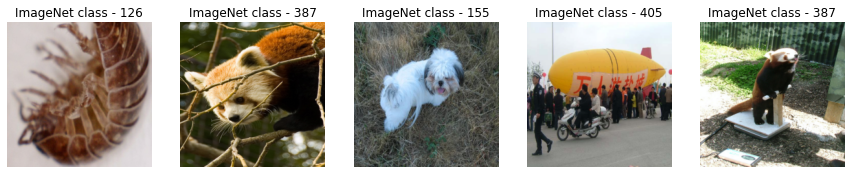

In [6]:
# Plot some inputs!

nr_images = 5
fig, axes = plt.subplots(nrows=1, ncols=nr_images, figsize=(nr_images*3, int(nr_images*2/3)))
for i in range(nr_images):
    axes[i].imshow((np.moveaxis(quantus.denormalise(x_batch[i].cpu().numpy()), 0, -1) * 255).astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
    axes[i].title.set_text(f"ImageNet class - {y_batch[i].item()}")
    axes[i].axis("off")
plt.show()

### 1.2 Load a pre-trained model

In this example we load a pre-trained ResNet-18 model but it goes without saying that any model works.

In [7]:
def evaluate_model(model, data, device):
    """Evaluate accuracy of torch model."""
    model.eval()
    logits = torch.Tensor().to(device)
    targets = torch.LongTensor().to(device)

    with torch.no_grad():
        for images, _, labels in data:
            images, labels = images.to(device), labels.to(device)
            logits = torch.cat([logits, model(images)])
            targets = torch.cat([targets, labels])
            
    return np.mean(np.argmax(logits.cpu().numpy(), axis=1) == targets.cpu().numpy())
    
# Load pre-trained ResNet18 model.
model = torchvision.models.resnet18(pretrained=True)
model = model.to(device)

# Evaluate model performance.
print(f"\nModel test accuracy: {(100 * evaluate_model(model.to(device), test_loader, device)):.2f}%")


Model test accuracy: 85.90%


### 1.3 Generate attribution-based explanations

There exist multiple ways to generate explanations for neural network models e.g., using `captum` or `innvestigate` libraries. In this example, we rely on the `quantus.explain` functionality (a simple wrapper around `captum`) however use whatever approach or library you'd like to create your explanations.

**Requirements.**

* **Data type.** Similar to the x-y pairs, the attributions should also be of type `np.ndarray`
* **Shape.** Sharing all the same dimensions as the input (expect for nr_channels which for explanations is equal to 1). For example, if x_batch is of size (128, 3, 224, 224) then the attributions should be of size (128, 1, 224, 224).

In [8]:
# Generate Integrated Gradients attributions of the first batch of the test set.
a_batch = quantus.explain(model, x_batch, y_batch, method="IntegratedGradients", normalise=True)

# Save x_batch and y_batch as numpy arrays that will be used to call metric instances.
x_batch, s_batch, y_batch = x_batch.cpu().numpy(), s_batch.cpu().numpy(), y_batch.cpu().numpy()

# Make sure s_batch is of correct shape.
s_batch = s_batch.reshape(24, 1, 224, 224)

# Quick assert.
assert [isinstance(obj, np.ndarray) for obj in [x_batch, y_batch, s_batch, a_batch]]

Visulize attributions given model and paris of input-output.

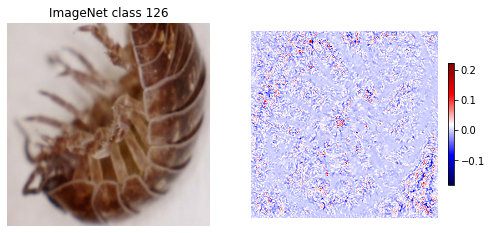

In [9]:
index = random.randint(0, len(x_batch)-1)

# Plot examplary explanations!
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
axes[0].imshow(np.moveaxis(quantus.denormalise(x_batch[index], **{"img_size": 224}), 0, -1), vmin=0.0, vmax=1.0)
axes[0].title.set_text(f"ImageNet class {y_batch[index].item()}")
exp = axes[1].imshow(a_batch[index], cmap="seismic") 
fig.colorbar(exp, fraction=0.03, pad=0.05); 
axes[0].axis("off"); axes[1].axis("off"); plt.show()

## 2. Evaluation using `Quantus`

As a preliminary step to evaluating the explanations using all the available metrics in the library, we will first view what categories and metrics we have available.

In [9]:
# Let's view what metrics categories are available.
quantus.available_categories()

['Faithfulness',
 'Robustness',
 'Localisation',
 'Complexity',
 'Randomisation',
 'Axiomatic']

In [10]:
# In each category, let's view the available metrics.
metrics = quantus.available_metrics()
metrics

{'Axiomatic': ['Completeness', 'NonSensitivity'],
 'Complexity': ['Sparseness', 'Complexity', 'Effective Complexity'],
 'Faithfulness': ['Faithfulness Correlation',
  'Faithfulness Estimate',
  'Pixel-Flipping',
  'Region Segmentation',
  'Monotonicity Arya',
  'Monotonicity Nguyen',
  'Selectivity',
  'SensitivityN',
  'IROF'],
 'Localisation': ['Pointing Game',
  'Top-K Intersection',
  'Relevance Mass Accuracy',
  'Relevance Mass Ranking',
  'Attribution Localisation ',
  'AUC'],
 'Randomisation': ['Model Parameter Randomisation', 'Random Logit'],
 'Robustness': ['Continuity Test',
  'Local Lipschitz Estimate',
  'Max-Sensitivity',
  'Avg-Sensitivity']}

### 2.1 Faithfulness metrics 

Score explanations using the following faithfulness metrics:

* Faithfulness Correlation (Bhatt et al., 2020)
* Faithfulness Estimate (Alvarez-Melis et al., 2018, 2019)
* Pixel-Flipping (Bach et al., 2015)
* Region Segmentation (Samek et al., 2015)
* Monotonicity-Arya (Arya et al., 2019)
* Monotonicity-Nguyen (Nguyen et al., 2019)
* Infidelity (Yeh et al., 2010)
* Selectivity (Montavan et al., 2018)
* SensitivityN (Ancona et al., 2018)
* IROF (Rieger et al., 2020)

In [11]:
# Return faithfulness correlation scores in an one-liner - by calling the metric instance.
quantus.FaithfulnessCorrelation(**{
    "nr_runs": 100,  
    "subset_size": 224,  
    "perturb_baseline": "black",
    "perturb_func": quantus.baseline_replacement_by_indices,
    "similarity_func": quantus.correlation_pearson,  
    "abs": False,  
})(model=model, 
   x_batch=x_batch, 
   y_batch=y_batch,
   a_batch=a_batch,
   **{"device": device})

WARNINGS.

The Faithfulness Correlation metric is likely to be sensitive to the choice of baseline value 'perturb_baseline', size of subset |S| 'subset_size' and the number of runs (for each input and explanation pair) 'nr_runs'. 
To avoid misinterpretation of scores, consider all relevant hyperparameters of the metric (by calling .get_params of the metric instance). 
For further reading see Bhatt, Umang, Adrian Weller, and José MF Moura. 'Evaluating and aggregating feature-based model explanations.' arXiv preprint arXiv:2005.00631 (2020).
To disable warnings set disable_warnings=True in the initialisation of metric instance.

Normalising attributions may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.



[-0.051638896903890834]

In [12]:
# Return faithfulness estimate scores in an one-liner - by calling the metric instance.
quantus.FaithfulnessEstimate(**{
    "perturb_func": quantus.baseline_replacement_by_indices,
    "similarity_func": quantus.correlation_pearson,
    "img_size": 224,  
    "features_in_step": 224,  
    "perturb_baseline": "black",  
    "pixels_in_step": 28,
})(model=model, 
   x_batch=x_batch, 
   y_batch=y_batch,
   a_batch=a_batch,
   **{"device": device})

WARNINGS.

The Faithfulness Estimate metric is likely to be sensitive to the choice of baseline value 'perturb_baseline' and similarity function 'similarity_func'. 
To avoid misinterpretation of scores, consider all relevant hyperparameters of the metric (by calling .get_params of the metric instance). 
For further reading see Alvarez-Melis, David, and Tommi S. Jaakkola. 'Towards robust interpretability with self-explaining neural networks.' arXiv preprint arXiv:1806.07538 (2018).
To disable warnings set disable_warnings=True in the initialisation of metric instance.

Normalising attributions may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.



[-0.3694694604679209,
 -0.20731288112614557,
 -0.7568408943397847,
 -0.7976346907844335,
 -0.011423865708311054,
 -0.25127645611968424,
 -0.5692086846682503,
 -0.27645268754364727,
 0.29365449203462185,
 -0.40165029639014294,
 -0.027358003803070297,
 -0.054201477001632845,
 -0.04865845394541754,
 -0.624859584695098,
 -0.4567108698890308,
 -0.09755120160448741,
 -0.6011594317022045,
 -0.41909505708097095,
 0.014338539688119517,
 -0.3502665865083259,
 -0.3247018141072607,
 -0.3534249182114204,
 -0.4246141521385559,
 0.37243486952091176]

In [13]:
# Return monotonicity scores in an one-liner - by calling the metric instance.
quantus.MonotonicityArya(**{
    "features_in_step": 224,
    "perturb_baseline": "black",
    "perturb_func": quantus.baseline_replacement_by_indices,
    "similarity_func": quantus.correlation_spearman,
})(model=model, 
   x_batch=x_batch, 
   y_batch=y_batch,
   a_batch=a_batch,
   **{"device": device})

WARNINGS.

The Monotonicity Arya metric is likely to be sensitive to the choice of baseline value 'perturb_baseline'. 
To avoid misinterpretation of scores, consider all relevant hyperparameters of the metric (by calling .get_params of the metric instance). 
For further reading see Arya, Vijay, et al. 'One explanation does not fit all: A toolkit and taxonomy of ai explainability techniques.' arXiv preprint arXiv:1909.03012 (2019).
To disable warnings set disable_warnings=True in the initialisation of metric instance.

Normalising attributions and taking their absolute values may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.



[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [14]:
# Return monotonicity scores in an one-liner - by calling the metric instance.
quantus.MonotonicityNguyen(**{
    "nr_samples": 10,
    "features_in_step": 3136,
    "perturb_baseline": "uniform",
    "perturb_func": quantus.baseline_replacement_by_indices,
    "similarity_func": quantus.correlation_spearman,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=a_batch,
   **{"device": device})

WARNINGS.

The Monotonicity Nguyen metric is likely to be sensitive to the choice of baseline value 'perturb_baseline', threshold value 'eps' and number of samples to iterate over 'nr_samples'. 
To avoid misinterpretation of scores, consider all relevant hyperparameters of the metric (by calling .get_params of the metric instance). 
For further reading see Nguyen, An-phi, and María Rodríguez Martínez. 'On quantitative aspects of model interpretability.' arXiv preprint arXiv:2007.07584 (2020).
To disable warnings set disable_warnings=True in the initialisation of metric instance.

Normalising attributions and taking their absolute values may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.



[0.7617647058823529,
 0.7794117647058825,
 0.02058823529411765,
 -0.049999999999999996,
 -0.008823529411764706,
 0.6794117647058824,
 0.3029411764705882,
 0.7558823529411764,
 0.4205882352941176,
 0.14411764705882352,
 -0.21176470588235297,
 0.19999999999999998,
 0.07941176470588236,
 0.31764705882352945,
 -0.3205882352941176,
 0.5676470588235295,
 0.3852941176470588,
 0.5735294117647058,
 0.5205882352941177,
 0.03529411764705882,
 0.5470588235294118,
 0.611764705882353,
 -0.0588235294117647,
 0.7441176470588236]

WARNINGS.

The Pixel Flipping metric is likely to be sensitive to the choice of baseline value 'perturb_baseline'. 
To avoid misinterpretation of scores, consider all relevant hyperparameters of the metric (by calling .get_params of the metric instance). 
For further reading see Bach, Sebastian, et al. 'On pixel-wise explanations for non-linear classifier decisions by layer - wise relevance propagation.' PloS one 10.7 (2015) e0130140..
To disable warnings set disable_warnings=True in the initialisation of metric instance.

Normalising attributions may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.



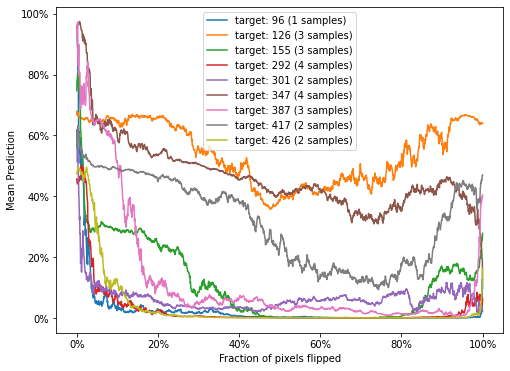

In [15]:
# Create the pixel-flipping experiment.
pixel_flipping = quantus.PixelFlipping(**{
    "features_in_step": 28,
    "perturb_baseline": "black",
    "perturb_func": quantus.baseline_replacement_by_indices,
})
    
# Call the metric instance to produce scores.
scores = pixel_flipping(model=model,
                        x_batch=x_batch,
                        y_batch=y_batch,
                        a_batch=a_batch,
                        **{"device": device})

# Plot example!
pixel_flipping.plot(y_batch=y_batch, scores=scores)

WARNINGS.

The Region Perturbation metric is likely to be sensitive to the choice of baseline value 'perturb_baseline'. 
To avoid misinterpretation of scores, consider all relevant hyperparameters of the metric (by calling .get_params of the metric instance). 
For further reading see Bach, Sebastian, et al. 'On pixel-wise explanations for non-linear classifier decisions by layer - wise relevance propagation.' PloS one 10.7 (2015): e0130140.
To disable warnings set disable_warnings=True in the initialisation of metric instance.

Normalising attributions may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.



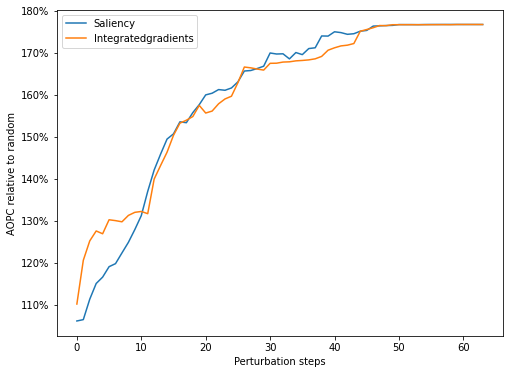

In [16]:
# Create the region perturbation experiment.
region_perturb = quantus.RegionPerturbation(**{
    "patch_size": 28,
    "regions_evaluation": 100,
    "img_size": 224,
    "random_order": False,
    "perturb_func": quantus.baseline_replacement_by_patch,
    "perturb_baseline": "uniform",  
})
    
# Call the metric instance to produce scores.
results = {method: region_perturb(model=model, 
                                  x_batch=x_batch,
                                  y_batch=y_batch,
                                  a_batch=None,
                                  **{"explain_func": quantus.explain, "method": method, "device": device}) for method in ["Saliency", "IntegratedGradients"]}

# Plot example!
region_perturb.plot(results=results)

WARNINGS.

The Selectivity metric is likely to be sensitive to the choice of baseline value 'perturb_baseline' and the patch size for masking 'patch_size'. 
To avoid misinterpretation of scores, consider all relevant hyperparameters of the metric (by calling .get_params of the metric instance). 
For further reading see Montavon, Grégoire, Wojciech Samek, and Klaus-Robert Müller. 'Methods for interpreting and understanding deep neural networks.' Digital Signal Processing 73 (2018): 1-15.
To disable warnings set disable_warnings=True in the initialisation of metric instance.

Normalising attributions may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.



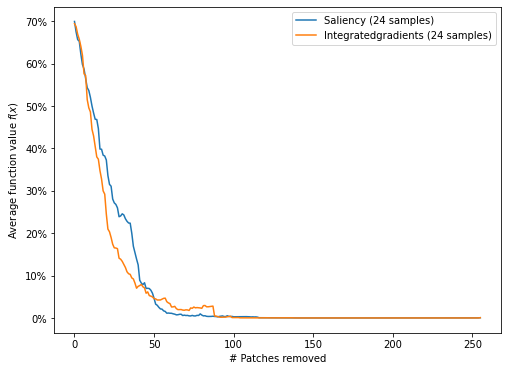

In [17]:
# Create the selectivity experiment.
selectivity = quantus.Selectivity(**{
    "patch_size": 14,
    "perturb_func": quantus.baseline_replacement_by_patch,
    "perturb_baseline": "black",  
})
    
# Call the metric instance to produce scores.
results = {method: selectivity(model=model, 
                               x_batch=x_batch,
                               y_batch=y_batch,
                               a_batch=None,
                               **{"explain_func": quantus.explain, "method": method, "device": device}) for method in ["Saliency", "IntegratedGradients"]}

# Plot example!
selectivity.plot(results=results)

WARNINGS.

The Sensitivity N metric is likely to be sensitive to the choice of baseline value 'perturb_baseline', the patch size for masking 'patch_size', similarity function 'similarity_func' and the number of features to iteratively evaluate 'n_max_percentage'. 
To avoid misinterpretation of scores, consider all relevant hyperparameters of the metric (by calling .get_params of the metric instance). 
For further reading see Ancona, Marco, et al. 'Towards better understanding of gradient-based attribution methods for deep neural networks.' arXiv preprint arXiv:1711.06104 (2017).
To disable warnings set disable_warnings=True in the initialisation of metric instance.

Normalising attributions may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.



No handles with labels found to put in legend.


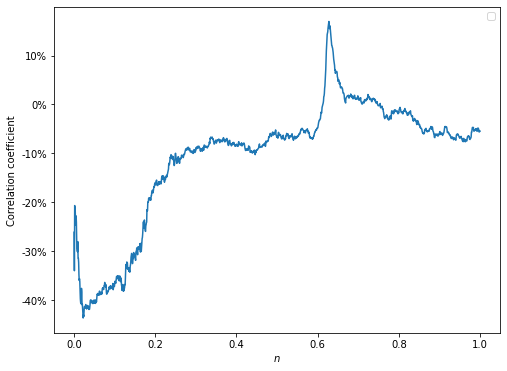

In [18]:
# Create the sensitivity-n experiment.
sensitivity_n = quantus.SensitivityN(**{
    "features_in_step": 28,
    "n_max_percentage": 0.8,
    "img_size": 224,
    "similarity_func": quantus.correlation_pearson,
    "perturb_func": quantus.baseline_replacement_by_indices,
    "perturb_baseline": "uniform",  
})
# Call the metric instance to produce scores.
results = sensitivity_n(model=model, 
                        x_batch=x_batch,
                        y_batch=y_batch,
                        a_batch=None,
                        **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

# Plot example!
sensitivity_n.plot(results=results)

# TODO. The curves looks different than in paper?

In [19]:
# Return IFOF scores in an one-liner - by calling the metric instance.
results = {method: quantus.IterativeRemovalOfFeatures(**{
    "segmentation_method": "slic",
    "perturb_baseline": "mean",
    "perturb_func": quantus.baseline_replacement_by_indices,
})(model=model,
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": method, "device": device}) for method in ["Gradient", "Saliency", "IntegratedGradients", "GradientShap"]}

results

WARNINGS.

The Iterative Removal Of Features metric is likely to be sensitive to the choice of baseline value 'perturb_baseline' and the method to segment the image 'segmentation_method'. 
To avoid misinterpretation of scores, consider all relevant hyperparameters of the metric (by calling .get_params of the metric instance). 
For further reading see Rieger, Laura, and Lars Kai Hansen. 'Irof: a low resource evaluation metric for explanation methods.' arXiv preprint arXiv:2003.08747 (2020).
To disable warnings set disable_warnings=True in the initialisation of metric instance.

Normalising attributions may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.



/content/drive/MyDrive/Projects/quantus/quantus/helpers/utils.py:41: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  sigma=kwargs.get("slic_sigma", 0.1),


WARNINGS.

The Iterative Removal Of Features metric is likely to be sensitive to the choice of baseline value 'perturb_baseline' and the method to segment the image 'segmentation_method'. 
To avoid misinterpretation of scores, consider all relevant hyperparameters of the metric (by calling .get_params of the metric instance). 
For further reading see Rieger, Laura, and Lars Kai Hansen. 'Irof: a low resource evaluation metric for explanation methods.' arXiv preprint arXiv:2003.08747 (2020).
To disable warnings set disable_warnings=True in the initialisation of metric instance.

Normalising attributions may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.

WARNINGS.

The Iterative Removal Of Features metric is likely to be sensitive to the choice of baseline value 'perturb_baseline' and the method to segment the image 'segmentation_method'. 
To avoid misinterpretation of scores, consider all relevant hyperparameters of the metric (by 

{'Gradient': [40.513171394957844],
 'GradientShap': [40.4938729406875],
 'IntegratedGradients': [40.473008192493246],
 'Saliency': [40.54397955260604]}

In [20]:
"""
# Return infidelity scores in an one-liner - by calling the metric instance.
quantus.Infidelity(**{
    "loss_func": quantus.mse,
    "img_size": 224,
    "perturb_patch_sizes": [8, 14, 28],
    "perturb_baseline": "black",  
    "perturb_func": quantus.baseline_replacement_by_patch,
})(model=model, 
   x_batch=x_batch, 
   y_batch=y_batch,
   a_batch=a_batch,
   **{"device": device})
"""

'\n# Return infidelity scores in an one-liner - by calling the metric instance.\nquantus.Infidelity(**{\n    "loss_func": quantus.mse,\n    "img_size": 224,\n    "perturb_patch_sizes": [8, 14, 28],\n    "perturb_baseline": "black",  \n    "perturb_func": quantus.baseline_replacement_by_patch,\n})(model=model, \n   x_batch=x_batch, \n   y_batch=y_batch,\n   a_batch=a_batch,\n   **{"device": device})\n'

### 2.2 Robustness metrics 

Score explanations using the following robustness metrics:

* Local Lipschitz Estimate (Alvarez-Melis et al., 2018; 2019)
* Max-Sensitivity (Yeh at el., 2019)
* Avg-Sensitivity (Yeh at el., 2019)
* Continuity (Montavan et al., 2017)
* Input Independence Rate (Yang et al., 2019)

In [21]:
# Return local lipschitzEstimate estimate scores in an one-liner - by calling the metric instance.
quantus.LocalLipschitzEstimate(**{
    "nr_samples": 10,
    "perturb_std": 0.1,
    "perturb_mean": 0.1,
    "norm_numerator": quantus.distance_euclidean,
    "norm_denominator": quantus.distance_euclidean,    
    "perturb_func": quantus.gaussian_noise,
    "similarity_func": quantus.lipschitz_constant,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": "Saliency", "device": device})

WARNINGS.

The Local Lipschitz Estimate metric is likely to be sensitive to the choice of amount of noise added 'perturb_std', the number of samples iterated over 'nr_samples', the function to perturb the input 'perturb_func', the similarity metric 'similarity_func' as well as norm calculations on the numerator and denominator of the lipschitz equation i.e., 'norm_numerator' and 'norm_denominator'. 
To avoid misinterpretation of scores, consider all relevant hyperparameters of the metric (by calling .get_params of the metric instance). 
For further reading see Alvarez-Melis, David, and Tommi S. Jaakkola. 'On the robustness of interpretability methods.' arXiv preprint arXiv:1806.08049 (2018). and Alvarez-Melis, David, and Tommi S. Jaakkola. 'Towards robust interpretability with self-explaining neural networks.' arXiv preprint arXiv:1806.07538 (2018).
To disable warnings set disable_warnings=True in the initialisation of metric instance.

Normalising attributions may destroy or skew info

[49.63780722856134,
 33.89456836536263,
 21.199467783156884,
 29.945846778742418,
 20.978024732378756,
 15.952398780151121,
 31.9537226733936,
 37.277670166168825,
 49.895462895819115,
 51.66468016574337,
 58.88228181444375,
 54.407846481498105,
 36.52617974637502,
 20.640512555696418,
 62.84200466668754,
 63.329099073086105,
 19.955014334642954,
 27.656093815934685,
 35.72401729259016,
 55.00282155894273,
 35.022899716335594,
 23.530865914619103,
 27.322118948602565,
 30.4964745542114]

In [23]:
# Return max sensitivity scores in an one-liner - by calling the metric instance.
quantus.MaxSensitivity(**{
    "nr_samples": 10,
    "perturb_radius": 0.2,
    "norm_numerator": quantus.fro_norm,
    "norm_denominator": quantus.fro_norm,
    "perturb_func": quantus.uniform_sampling,
    "similarity_func": quantus.difference,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": "Saliency", "device": device})

WARNINGS.

The Max Sensitivity metric is likely to be sensitive to the choice of amount of noise added 'perturb_radius', the number of samples iterated over 'nr_samples', the function to perturb the input 'perturb_func', the similarity metric 'similarity_func' as well as norm calculations on the numerator and denominator of the sensitivity equation i.e., 'norm_numerator' and 'norm_denominator'. 
To avoid misinterpretation of scores, consider all relevant hyperparameters of the metric (by calling .get_params of the metric instance). 
For further reading see Yeh, Chih-Kuan, et al. 'On the (in) fidelity and sensitivity for explanations.' arXiv preprint arXiv:1901.09392 (2019).
To disable warnings set disable_warnings=True in the initialisation of metric instance.


[0.020986177,
 0.028665544,
 0.03733411,
 0.036201444,
 0.015147975,
 0.029962882,
 0.023529133,
 0.018055934,
 0.031508114,
 0.016761487,
 0.016001351,
 0.023563579,
 0.015848612,
 0.028245753,
 0.03436015,
 0.01683574,
 0.041796565,
 0.03209563,
 0.041271403,
 0.022729518,
 0.0151867205,
 0.026072254,
 0.04823527,
 0.005500818]

In [25]:
# Return avg sensitivity scores in an one-liner - by calling the metric instance.
quantus.AvgSensitivity(**{
    "nr_samples": 10,
    "perturb_radius": 0.2,
    "norm_numerator": quantus.fro_norm,
    "norm_denominator": quantus.fro_norm,
    "perturb_func": quantus.uniform_sampling,
    "similarity_func": quantus.difference,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": "Saliency", "device": device})

WARNINGS.

The Avg Sensitivity metric is likely to be sensitive to the choice of amount of noise added 'perturb_radius', the number of samples iterated over 'nr_samples', the function to perturb the input 'perturb_func', the similarity metric 'similarity_func' as well as norm calculations on the numerator and denominator of the sensitivity equation i.e., 'norm_numerator' and 'norm_denominator'. 
To avoid misinterpretation of scores, consider all relevant hyperparameters of the metric (by calling .get_params of the metric instance). 
For further reading see Yeh, Chih-Kuan, et al. 'On the (in) fidelity and sensitivity for explanations.' arXiv preprint arXiv:1901.09392 (2019).
To disable warnings set disable_warnings=True in the initialisation of metric instance.


[0.020509639754891396,
 0.027986843138933182,
 0.03604348003864288,
 0.03257085382938385,
 0.013886665925383568,
 0.02735372819006443,
 0.02239507995545864,
 0.01739627495408058,
 0.031169608235359192,
 0.016314208507537842,
 0.015599007718265057,
 0.023037703707814217,
 0.015264829620718956,
 0.023134473711252213,
 0.033257514238357544,
 0.016344767063856125,
 0.039723120629787445,
 0.03157978504896164,
 0.039683230221271515,
 0.022359203547239304,
 0.014936139807105064,
 0.02492532506585121,
 0.044741228222846985,
 0.005468699615448713]

In [27]:
# Return continuity scores in an one-liner - by calling the metric instance.
quantus.Continuity(**{
    "nr_patches": 4,
    "nr_steps": 10,
    "img_size": 224,
    "perturb_baseline": "black",
    "similarity_func": quantus.correlation_spearman,
    "perturb_func": quantus.translation_x_direction,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

#print(f"Continutity correlation score: {continuity_test.continutity_correlation_score:.4f}")

WARNINGS.

The Continuity metric is likely to be sensitive to the choice of how many patches to split the input image to 'nr_patches', the number of steps to iterate over 'nr_steps', the value to replace the masking with 'perturb_baseline' and in what direction to translate the image 'perturb_func'. 
To avoid misinterpretation of scores, consider all relevant hyperparameters of the metric (by calling .get_params of the metric instance). 
For further reading see Montavon, Grégoire, Wojciech Samek, and Klaus-Robert Müller. 'Methods for interpreting and understanding deep neural networks.' Digital Signal Processing 73, 1-15 (2018.
To disable warnings set disable_warnings=True in the initialisation of metric instance.

Normalising attributions and taking their absolute values may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.



{0: {0: [859.7565097497431,
   691.3227347304721,
   386.5076126270631,
   307.63972114353965,
   451.60464853896826,
   1084.5117708606833,
   1232.6405016811987,
   1114.1837324383855,
   1282.4854672751808,
   1251.5332745694238],
  1: [784.921956277353,
   901.2525923910289,
   943.9572524361656,
   878.6679606935256,
   794.8242521060968,
   787.4551632827406,
   938.4564586193964,
   546.124725882125,
   514.3408863604627,
   1040.4814007934542],
  2: [806.1960833279741,
   645.7909949520993,
   496.56471419204655,
   354.08953944853255,
   483.7510472239531,
   1505.6027729374873,
   1234.0448593049932,
   876.4319996769655,
   1209.7784555138733,
   864.3435806006457],
  3: [661.1607052675117,
   902.1303132161465,
   1042.2407794374515,
   768.4754350429705,
   913.8865318041521,
   681.740583313753,
   851.4592619776481,
   406.20230328995683,
   396.5432495285054,
   1116.3530338604978],
  4: [21.502708435058594,
   20.83051872253418,
   22.65289306640625,
   19.086376190185

### 2.3 Localisation metrics

* Pointing Game (Zhang et al., 2018)
* Attribution Localisation (Kohlbrenner et al., 2020)
* TKI (Theiner et al., 2021)
* Relevance Rank Accuracy (Arras et al., 2021)
* Relevance Mass Accuracy (Arras et al., 2021)
* AUC (Arras et al., 2021)

In [17]:
# Return effective complexity scores in an one-liner - by calling the metric instance.
quantus.PointingGame(**{
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   s_batch=s_batch,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

WARNINGS.

The Pointing Game metric is likely to be sensitive to the choice of ground truth mask i.e., the 's_batch' input as well as if the attributions are normalised 'normalise' (and 'normalise_func') and/ or taking absolute values of such 'abs'. 
To avoid misinterpretation of scores, consider all relevant hyperparameters of the metric (by calling .get_params of the metric instance). 
For further reading see Zhang, Jianming, Baral, Sarah Adel, Lin, Zhe, Brandt, Jonathan, Shen, Xiaohui, and Sclaroff, Stan. 'Top-Down Neural Attention by Excitation Backprop.' International Journal of Computer Vision, 126:1084-1102 (2018).
To disable warnings set disable_warnings=True in the initialisation of metric instance.

Normalising attributions may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.



[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True]

In [11]:
# Return attribution localisation scores in an one-liner - by calling the metric instance.
quantus.AttributionLocalisation(**{
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   s_batch=s_batch,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

WARNINGS.

The Attribution Localisation metric is likely to be sensitive to the choice of ground truth mask i.e., the 's_batch', if size of the ground truth mask is taking into account 'weighted' as well as if attributions are normalised 'normalise' (and 'normalise_func') and/ or taking the absolute values of such 'abs'. 
To avoid misinterpretation of scores, consider all relevant hyperparameters of the metric (by calling .get_params of the metric instance). 
For further reading see Kohlbrenner M., Bauer A., Nakajima S., Binder A., Wojciech S., Lapuschkin S. 'Towards Best Practice in Explaining Neural Network Decisions with LRP.arXiv preprint arXiv:1910.09840v2 (2020)..
To disable warnings set disable_warnings=True in the initialisation of metric instance.

Normalising attributions and taking their absolute values may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.



[0.902934193611145,
 0.8993358612060547,
 0.786665678024292,
 0.41515806317329407,
 0.690796971321106,
 0.9175950288772583,
 0.6186028718948364,
 0.7473184466362,
 0.8202817440032959,
 0.5334773659706116,
 0.6741348505020142,
 0.3362452983856201,
 0.9011204242706299,
 0.5262629985809326,
 0.9715422987937927,
 0.6511207818984985,
 0.17642973363399506,
 0.5243772864341736,
 0.9632286429405212,
 0.35845404863357544,
 0.31553390622138977,
 0.61878502368927,
 0.14448963105678558,
 0.5837312340736389]

In [18]:
# Return tki scores in an one-liner - by calling the metric instance.
quantus.TopKIntersection(**{
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   s_batch=s_batch,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

WARNINGS.

The Top K Intersection metric is likely to be sensitive to the choice of ground truth mask i.e., the 's_batch', the number of features to consider 'k', if size of the ground truth mask is taking into account 'concept_influence' as well as if attributions are normalised 'normalise' (and 'normalise_func') and/ or taking absolute values of such 'abs'. 
To avoid misinterpretation of scores, consider all relevant hyperparameters of the metric (by calling .get_params of the metric instance). 
For further reading see Theiner, Jonas, Müller-Budack Eric, and Ewerth, Ralph. 'Interpretable Semantic Photo Geolocalization.' arXiv preprint arXiv:2104.14995 (2021).
To disable warnings set disable_warnings=True in the initialisation of metric instance.

Normalising attributions may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.



[0.908,
 0.991,
 0.999,
 0.464,
 0.973,
 0.998,
 0.653,
 0.977,
 0.9440000000000001,
 0.677,
 0.848,
 0.679,
 0.982,
 0.599,
 0.992,
 0.805,
 0.379,
 0.553,
 0.998,
 0.492,
 0.582,
 0.733,
 0.355,
 0.88]

In [13]:
# Return relevane rank accuracy scores in an one-liner - by calling the metric instance.
quantus.RelevanceRankAccuracy(**{
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   s_batch=s_batch,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

WARNINGS.

The Relevance Rank Accuracy metric is likely to be sensitive to the choice of ground truth mask i.e., the 's_batch' as well as if the attributions are normalised 'normalise' (and 'normalise_func') and/ or taking absolute values of such 'abs'. 
To avoid misinterpretation of scores, consider all relevant hyperparameters of the metric (by calling .get_params of the metric instance). 
For further reading see Arras, Leila, Osman, Ahmed, and Samek, Wojciech. 'Ground Truth Evaluation of Neural Network Explanations with CLEVR-XAI.' arXiv preprint, arXiv:2003.07258v2 (2021)..
To disable warnings set disable_warnings=True in the initialisation of metric instance.

Normalising attributions and taking their absolute values may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.



[0.9115635888501742,
 0.8122919267582189,
 0.6406887981537369,
 0.42600347915727077,
 0.5666691455343199,
 0.7288715192965315,
 0.6052360338074624,
 0.6497699115044248,
 0.7196103205213459,
 0.5184022515696038,
 0.6198885908809573,
 0.390342405618964,
 0.8585004298427008,
 0.5105111210507055,
 0.9520217892310916,
 0.6251428571428571,
 0.3753910323253389,
 0.5200534759358288,
 0.9109347442680776,
 0.36203306000260316,
 0.3690421455938697,
 0.5746146415221135,
 0.26985815602836877,
 0.541476407914764]

In [14]:
# Return relevane mass accuracy scores in an one-liner - by calling the metric instance.
quantus.RelevanceMassAccuracy(**{
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   s_batch=s_batch,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

WARNINGS.

The Relevance Mass Accuracy metric is likely to be sensitive to the choice of ground truth mask i.e., the 's_batch' as well as if the attributions are normalised 'normalise' (and 'normalise_func') and/ or taking absolute values of such 'abs'. 
To avoid misinterpretation of scores, consider all relevant hyperparameters of the metric (by calling .get_params of the metric instance). 
For further reading see Arras, Leila, Osman, Ahmed, and Samek, Wojciech. 'Ground Truth Evaluation of Neural Network Explanations with CLEVR-XAI.' arXiv preprint, arXiv:2003.07258v2 (2021)..
To disable warnings set disable_warnings=True in the initialisation of metric instance.

Normalising attributions may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.



[0.90791845,
 0.89949054,
 0.830462,
 0.43575242,
 0.707219,
 0.9149019,
 0.60369194,
 0.7521027,
 0.8135156,
 0.344407,
 0.63634515,
 0.7049541,
 0.9335369,
 0.5070416,
 0.9644104,
 0.6542671,
 -0.10340634,
 0.5177732,
 0.89916784,
 0.3822391,
 0.3095977,
 0.64354664,
 0.19804236,
 0.5484869]

In [15]:
# Return relevane mass accuracy scores in an one-liner - by calling the metric instance.
quantus.AUC(**{
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   s_batch=s_batch,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

WARNINGS.

The A U C metric is likely to be sensitive to the choice of ground truth mask i.e., the 's_batch' input as well as if absolute values 'abs' are taken of the attributions . 
To avoid misinterpretation of scores, consider all relevant hyperparameters of the metric (by calling .get_params of the metric instance). 
For further reading see Fawcett, Tom. 'An introduction to ROC analysis' Pattern Recognition Letters Vol 27, Issue 8, (2006).
To disable warnings set disable_warnings=True in the initialisation of metric instance.

Normalising attributions may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.



[0.49772960155861123,
 0.5003038267628459,
 0.5035280572152026,
 0.5031823337705527,
 0.4990923209905911,
 0.5003589556058767,
 0.4908501398958379,
 0.5046277861525081,
 0.5010613940538033,
 0.5066969162142652,
 0.49915845360693645,
 0.5173264831642611,
 0.498699409595703,
 0.5004873047794174,
 0.5062938349557224,
 0.5009632582879602,
 0.5115959529485913,
 0.5010099658745066,
 0.5008162207874105,
 0.50416247094779,
 0.5036650633012055,
 0.49966518253047715,
 0.5255739160569796,
 0.49999663826203566]

### 2.4 Randomization metrics

WARNINGS.

The Model Parameter Randomisation metric is likely to be sensitive to the choice of similarity metric 'similarity_func' and the order of the layer randomisation 'layer_order'. 
To avoid misinterpretation of scores, consider all relevant hyperparameters of the metric (by calling .get_params of the metric instance). 
For further reading see Adebayo, J., Gilmer, J., Muelly, M., Goodfellow, I., Hardt, M., and Kim, B. 'Sanity Checks for Saliency Maps.' arXiv preprint, arXiv:1810.073292v3 (2018).
To disable warnings set disable_warnings=True in the initialisation of metric instance.

Normalising attributions may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.

WARNINGS.

The Model Parameter Randomisation metric is likely to be sensitive to the choice of similarity metric 'similarity_func' and the order of the layer randomisation 'layer_order'. 
To avoid misinterpretation of scores, consider all relevant hyperparameters of the 

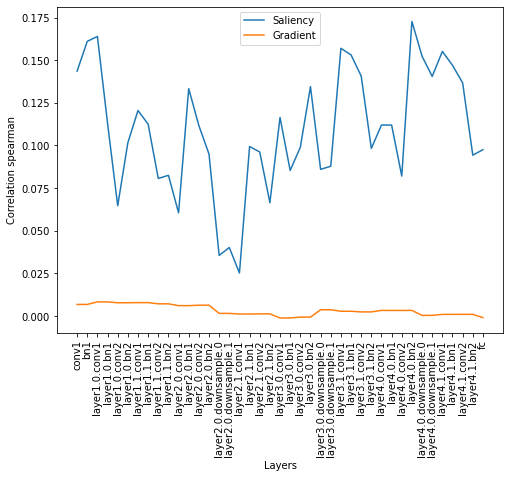

In [19]:
# Return model parameter randomization scores in an one-liner - by calling the metric instance.
results = {method: quantus.ModelParameterRandomisation(**{
    "layer_order": "bottom_up",
    "similarity_func": quantus.correlation_spearman,
    "normalize": True,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": method, "device": device}) for method in ["Saliency", "Gradient"]}

quantus.plot_model_parameter_randomisation_experiment(results=results, methods=["Saliency", "Gradient"], **{"similarity_metric": quantus.correlation_spearman.__name__.replace("_", " ").capitalize()})

In [20]:
# Return random logit scores in an one-liner - by calling the metric instance.
quantus.RandomLogit(**{
    "num_classes": 1000,
    "similarity_func": quantus.ssim,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": "Saliency", "device": device})

WARNINGS.

The Random Logit metric is likely to be sensitive to the choice of similarity metric 'similarity_func'. 
To avoid misinterpretation of scores, consider all relevant hyperparameters of the metric (by calling .get_params of the metric instance). 
For further reading see Sixt, Leon, Granz, Maximilian, and Landgraf, Tim. 'When Explanations Lie: Why Many Modified BP Attributions Fail.' arXiv preprint, arXiv:1912.09818v6 (2020).
To disable warnings set disable_warnings=True in the initialisation of metric instance.

Normalising attributions may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.



[0.7245094791150688,
 0.7433819406362756,
 0.7288747485202797,
 0.7574613144074813,
 0.7551824022479118,
 0.7334170006127769,
 0.748792504458427,
 0.7462042979635813,
 0.7147942104415833,
 0.7425717059251626,
 0.7641017608612166,
 0.7451525416600807,
 0.745562156090901,
 0.7646784616116257,
 0.749678736480519,
 0.7501242838304713,
 0.7348957689549682,
 0.7494316963693811,
 0.7425987896509071,
 0.7852054820279522,
 0.7288228094880044,
 0.7578842313240427,
 0.7769462571840713,
 0.717222429008599]

### 2.5 Complexity metrics

Score explanations using the following complexity metrics:

* Sparseness (Alvarez-Melis et al., 2018; 2019)
* Complexity (Yeh at el., 2019)
* Effective complexity (Yeh at el., 2019)

In [21]:
# Return sparseness scores in an one-liner - by calling the metric instance.
quantus.Sparseness(**{
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

WARNINGS.

The Sparseness metric is likely to be sensitive to the choice of normalising 'normalise' (and 'normalise_func') and if taking absolute values of attributions 'abs'. 
To avoid misinterpretation of scores, consider all relevant hyperparameters of the metric (by calling .get_params of the metric instance). 
For further reading see Chalasani, Prasad, et al. Concise explanations of neural networks using adversarial training.' International Conference on Machine Learning. PMLR, (2020).
To disable warnings set disable_warnings=True in the initialisation of metric instance.

Normalising attributions and taking their absolute values may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.



[0.5814384963843181,
 0.5616397954541773,
 0.5988847710405837,
 0.6259211181311499,
 0.6065162571664359,
 0.6123165655800569,
 0.5902415516861886,
 0.6478800683282369,
 0.6105994070185251,
 0.5834509609837358,
 0.5987399531744361,
 0.610662167702143,
 0.5957164503610796,
 0.5958331946853329,
 0.6097278099292849,
 0.5993784339332592,
 0.5848116424795201,
 0.5797103736388711,
 0.5865570863437063,
 0.5873522210345336,
 0.6138813778644929,
 0.5676492999001383,
 0.5296872569309186,
 0.6150543850782643]

In [22]:
# Return complexity scores in an one-liner - by calling the metric instance.
quantus.Complexity(**{
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

WARNINGS.

The Complexity metric is likely to be sensitive to the choice of normalising 'normalise' (and 'normalise_func') and if taking absolute values of attributions 'abs'. 
To avoid misinterpretation of scores, consider all relevant hyperparameters of the metric (by calling .get_params of the metric instance). 
For further reading see Bhatt, Umang, Adrian Weller, and José MF Moura. 'Evaluating and aggregating feature-based model explanations.' arXiv preprint arXiv:2005.00631 (2020).
To disable warnings set disable_warnings=True in the initialisation of metric instance.

Normalising attributions and taking their absolute values may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.



[10.196646797423398,
 10.244931648276625,
 10.147544942647679,
 10.062852203625443,
 10.136496131114875,
 10.110299739390598,
 10.1606907389178,
 9.99453080727362,
 10.101824700367617,
 10.19520330717984,
 10.139323536138273,
 10.093585351099957,
 10.153582905783257,
 10.141187555188363,
 10.11546921487746,
 10.159140948002173,
 10.191694467554608,
 10.185430058830862,
 10.184600808255823,
 10.168581090392232,
 10.122526575949713,
 10.225170347860587,
 10.315842021240154,
 10.099748883815508]

In [23]:
# Return effective complexity scores in an one-liner - by calling the metric instance.
quantus.EffectiveComplexity(**{
    "eps": 1e-5,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

WARNINGS.

The Effective Complexity metric is likely to be sensitive to the choice of normalising 'normalise' (and 'normalise_func') and if taking absolute values of attributions 'abs' and the choice of threshold 'eps'. 
To avoid misinterpretation of scores, consider all relevant hyperparameters of the metric (by calling .get_params of the metric instance). 
For further reading see Nguyen, An-phi, and María Rodríguez Martínez. 'On quantitative aspects of model interpretability.' arXiv preprint arXiv:2007.07584 (2020)..
To disable warnings set disable_warnings=True in the initialisation of metric instance.

Normalising attributions and taking their absolute values may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.



[50149,
 50159,
 50152,
 50136,
 50137,
 50127,
 50154,
 50111,
 50140,
 50158,
 50144,
 50149,
 50144,
 50145,
 50146,
 50149,
 50158,
 50162,
 50152,
 50160,
 50130,
 50150,
 50169,
 50124]

### 2.6 Axiomatic metrics

Score explanations using the following axiomatic metrics:

* Completeness (Montavon et al., 2018) - Additivity
* Non-sensitivity (Nguyen at el., 2020) - Dummy
* Symmetry
* Input invaraince

In [24]:
# Return completeness scores in an one-liner - by calling the metric instance.
quantus.Completeness(**{
    "abs": False,
    "disable_warings": True,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

WARNINGS.

The Completeness metric is likely to be sensitive to the choice of baseline value 'perturb_baseline' and the function to modify the model response 'output_func'. 
To avoid misinterpretation of scores, consider all relevant hyperparameters of the metric (by calling .get_params of the metric instance). 
For further reading see Sundararajan, Mukund, Ankur Taly, and Qiqi Yan. 'Axiomatic attribution for deep networks.' International Conference on Machine Learning. PMLR, (2017)..
To disable warnings set disable_warnings=True in the initialisation of metric instance.

Normalising attributions may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.



[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [31]:
# Return non-sensitivity scores in an one-liner - by calling the metric instance.
quantus.NonSensitivity(**{
    "abs": True,
    "eps": 1e-5,
    "n_samples": 10, 
    "perturb_baseline": "black",
    "perturb_func": quantus.baseline_replacement_by_indices,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

WARNINGS.

The Non Sensitivity metric is likely to be sensitive to the choice of baseline value 'perturb_baseline', the number of samples to iterate over 'n_samples' and the threshold value function for the feature to be considered having an insignificant contribution to the model. 
To avoid misinterpretation of scores, consider all relevant hyperparameters of the metric (by calling .get_params of the metric instance). 
For further reading see Nguyen, An-phi, and María Rodríguez Martínez. 'On quantitative aspects of model interpretability.' arXiv preprint arXiv:2007.07584 (2020)..
To disable warnings set disable_warnings=True in the initialisation of metric instance.

Normalising attributions and taking their absolute values may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.



[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]